In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from backtest_functions_v1b import *

### strategy 1: take simple mean of all 6 absa column

In [3]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

[*********************100%***********************]  1 of 1 completed


,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward_1d
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.093726
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,0.020380
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.024712
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.063197
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.083311


In [6]:
df.describe()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward_1d
count,1461.000000,1438.000000,1421.000000,1425.000000,1427.000000,1438.000000,1202.000000,1461.000000
mean,106.341547,0.204244,-0.067238,-0.012217,0.478250,0.510591,-0.417578,0.001323
std,56.654991,0.298990,0.253940,0.306260,0.199329,0.158141,0.388851,0.032388
min,18.000000,-0.760000,-0.850000,-1.000000,-0.550000,-0.166667,-1.000000,-0.159747
25%,65.000000,0.004545,-0.250000,-0.225000,0.377350,0.427068,-0.700000,-0.013760
50%,98.000000,0.229615,-0.077778,0.000000,0.500000,0.534783,-0.500000,-0.000007
75%,132.000000,0.436364,0.111765,0.217857,0.612500,0.620000,-0.213542,0.016019
max,378.000000,0.868421,0.700000,0.800000,1.000000,1.000000,1.000000,0.187465


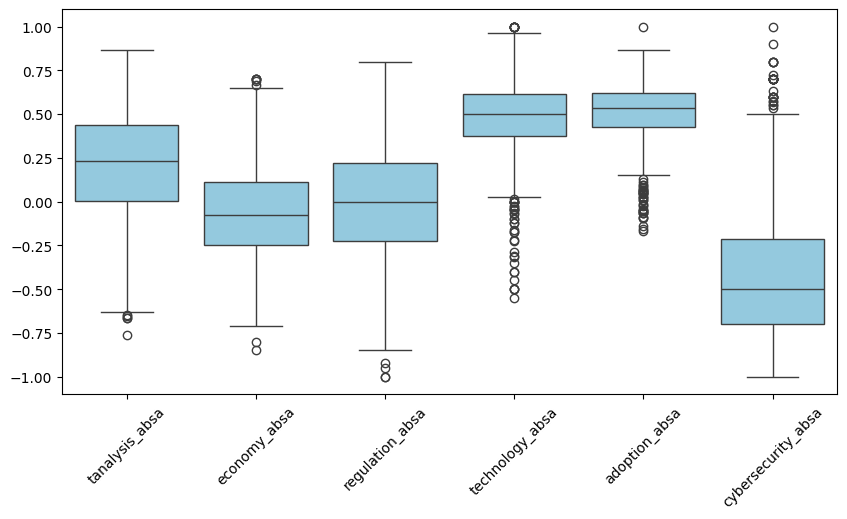

In [17]:
# plot the distribution of the columns
columns = ['tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa']

# boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[columns], color='skyblue')
plt.xticks(rotation=45)
plt.show()

In [3]:
cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
df['signal'] = df[cols].mean(axis=1)
df.drop(columns=cols, inplace=True)
df.drop(columns=['news_count'], inplace=True)
df.head()

,return_forward_1d,signal
2021-01-01,0.093726,0.223380
2021-01-02,0.020380,0.325500
2021-01-03,-0.024712,0.408182
2021-01-04,0.063197,0.224037
2021-01-05,0.083311,0.565286


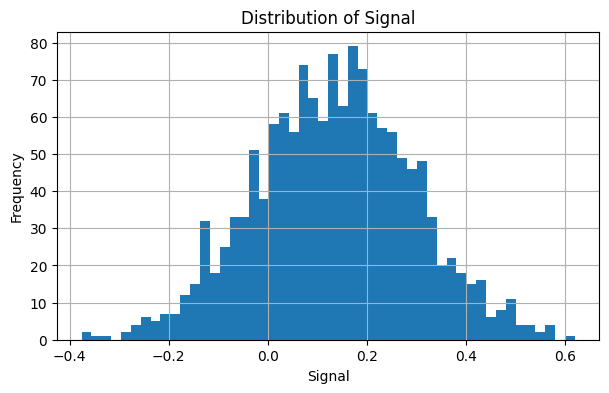

In [4]:
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

In [5]:
# Signal smoothing
df['signal'] = df['signal'].ewm(span=3).mean()
# df['signal'] = df['signal'].rolling(window=3).mean()


Overall Annual Return: 27.43%
Overall Annual Sharpe Ratio: 2.3629
Maximum Drawdown: -5.67 %
Win/Loss Ratio: 1.06
Alpha: 0.2158
Beta: 0.1212

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.636251    0.159216     0.110283      0.547248       3.996150
1  2022       0.022143    0.075935     0.062175      0.074924       0.291612
2  2023       0.167923    0.088155     0.153303      0.003367       1.904866
3  2024       0.270892    0.120658     0.206383      0.085315       2.245125


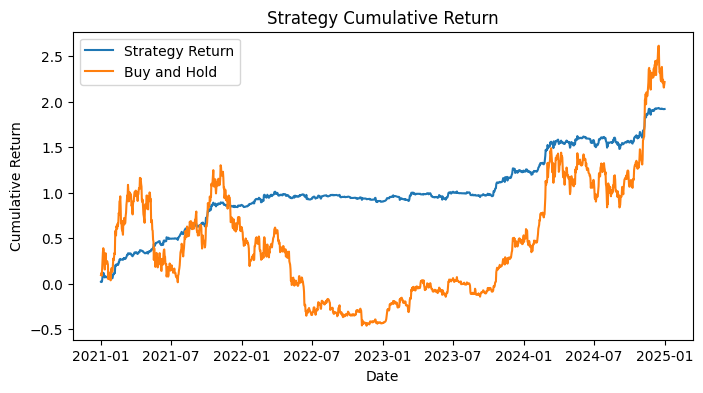

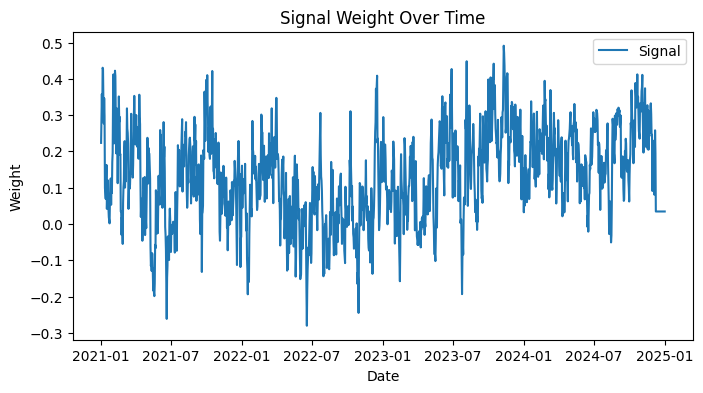

In [6]:
run_backtest(df)

Overall Annual Return: 27.09%
Overall Annual Sharpe Ratio: 2.2451
Maximum Drawdown: -5.38 %
Win/Loss Ratio: 1.1
Alpha: 0.0853
Beta: 0.2064

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.270892    0.120658     0.206383      0.085315       2.245125


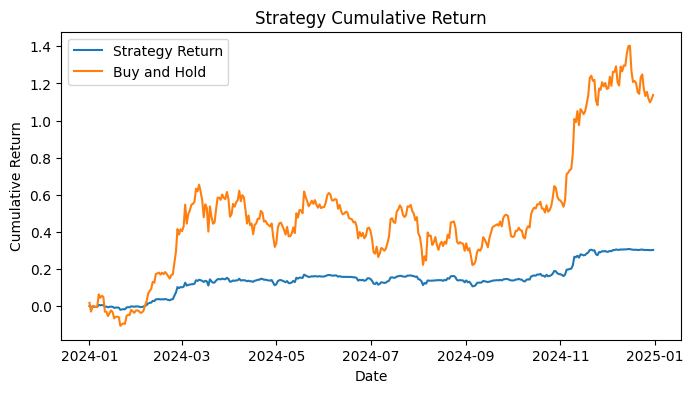

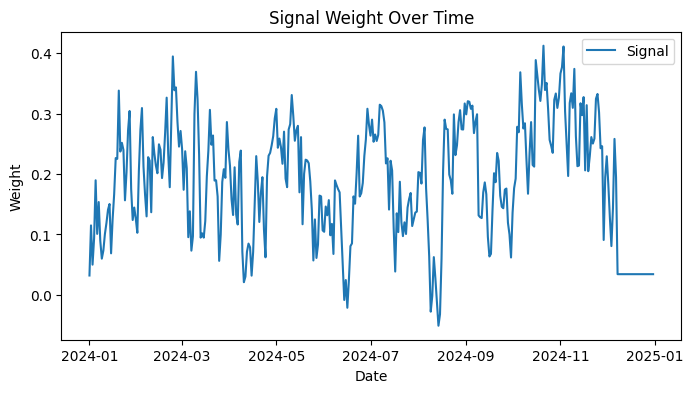

In [7]:
# backtest 2024 only
df = df[df.index.year == 2024]

run_backtest(df)

### strategy 2: random forest classifier

In [8]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward_1d
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.093726
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,0.020380
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.024712
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.063197
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.083311


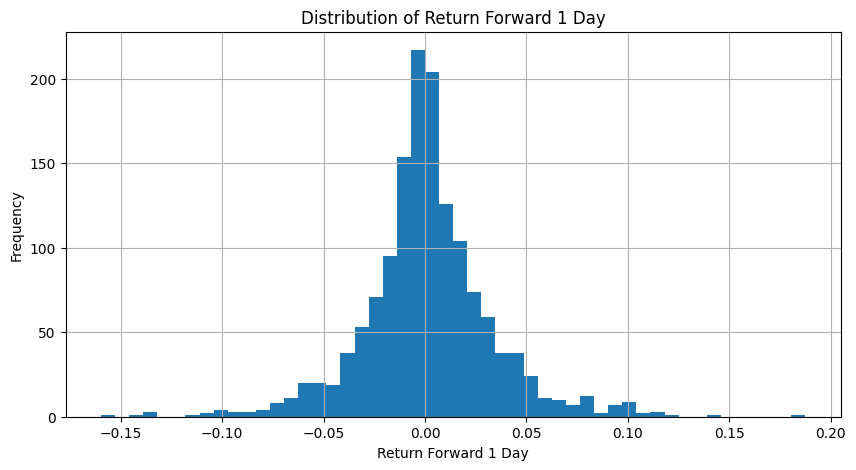

In [9]:
# plot return distribution
df['return_forward_1d'].hist(bins=50, figsize=(10, 5))
plt.title('Distribution of Return Forward 1 Day')
plt.xlabel('Return Forward 1 Day')
plt.ylabel('Frequency')
plt.show()

In [10]:
# classify the return into 3 classes

df['signal'] = 0
df.loc[df['return_forward_1d'] > 0.01, 'signal'] = 1
df.loc[df['return_forward_1d'] < -0.01, 'signal'] = -1

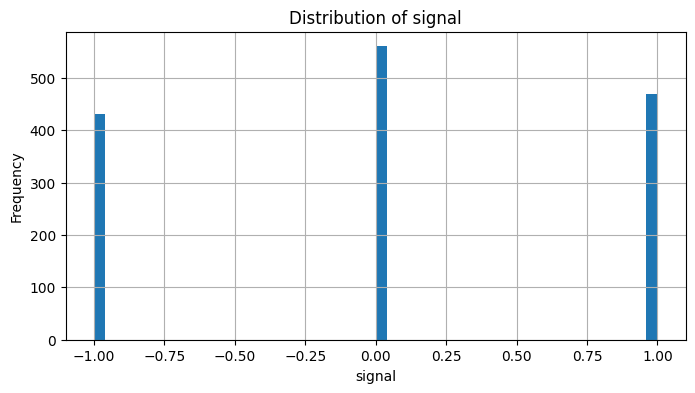

In [11]:
# plot signal distribution
df['signal'].hist(bins=50, figsize=(8, 4))
plt.title('Distribution of signal')
plt.xlabel('signal')
plt.ylabel('Frequency')
plt.show()

In [12]:
# split the dataset into 7:3
train_size = int(len(df) * 0.7)
test_size = int(len(df) * 0.3)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

signal_columns = ['tanalysis_absa', 'economy_absa', 
                  'regulation_absa', 'technology_absa', 
                  'adoption_absa', 'cybersecurity_absa']

# Check dataset sizes
print(f"Training set size: {train_df.shape[0]}")
print(train_df.groupby(train_df.index.year).size(), '\n')

print(f"Test set size: {test_df.shape[0]}")
print(test_df.groupby(test_df.index.year).size(), '\n')

# split to X and y
X_train = train_df[signal_columns].fillna(method='ffill').fillna(method='bfill')
y_train = train_df['signal']

X_test = test_df[signal_columns].fillna(method='ffill').fillna(method='bfill')
y_test = test_df['signal']

Training set size: 1022
2021    365
2022    365
2023    292
dtype: int64 

Test set size: 439
2023     73
2024    366
dtype: int64 



Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.3485


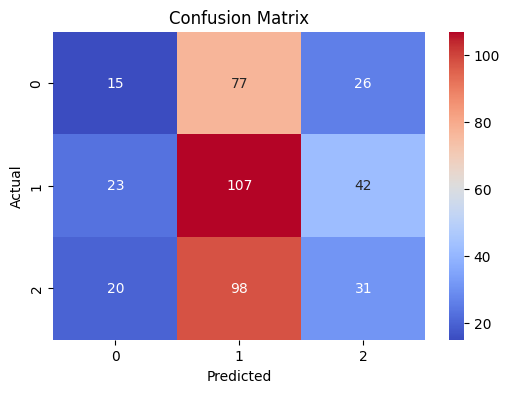

Classification Report:
               precision    recall  f1-score   support

          -1       0.26      0.13      0.17       118
           0       0.38      0.62      0.47       172
           1       0.31      0.21      0.25       149

    accuracy                           0.35       439
   macro avg       0.32      0.32      0.30       439
weighted avg       0.32      0.35      0.32       439



In [13]:
# Random Forest Classifier

# Hyperparameter Grid
param_grid = {
  'n_estimators': [50, 100, 200],
  'max_depth': [10, 20, 30],
  'min_samples_split': [2, 5, 10],
  'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
  estimator=rf,
  param_grid=param_grid,
  cv=5,
  n_jobs=-1,
  scoring='accuracy',
  verbose=1
)

# Train the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Initialize the best estimator
best_rf = grid_search.best_estimator_

# Predict on Test Set
y_pred = best_rf.predict(X_test)

# Evaluation Metrics
accuracy = best_rf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Overall Annual Return: 18.79%
Overall Annual Sharpe Ratio: 0.5644
Maximum Drawdown: -25.28 %
Win/Loss Ratio: 0.94
Alpha: 0.0564
Beta: 0.1197

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023       0.408088    0.315954     0.240740     -0.097107       1.291606
1  2024       0.144015    0.336596     0.101123      0.053086       0.427856


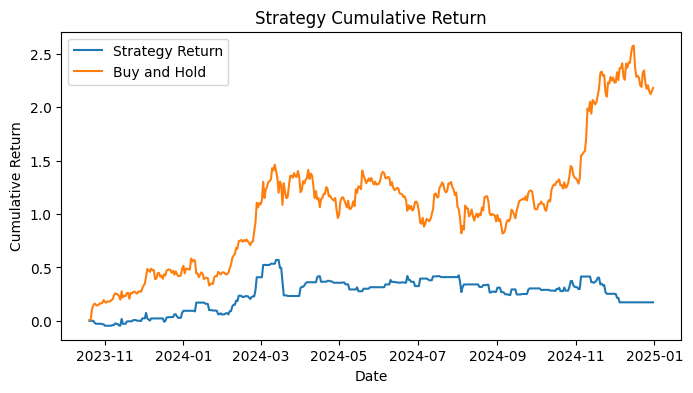

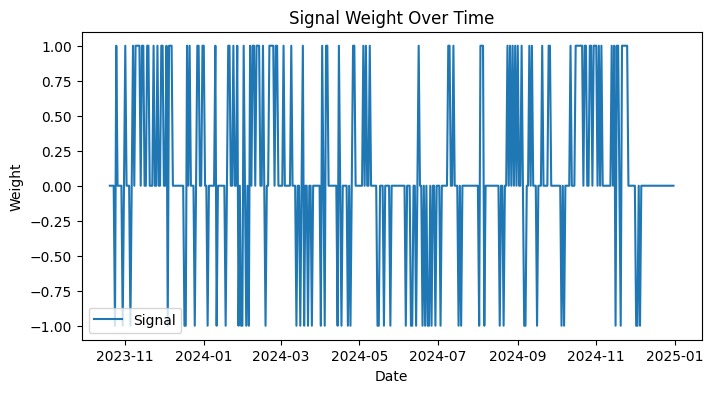

In [14]:
test_df['signal'] = y_pred
run_backtest(test_df)

### strategy 3: investigate each feature

In [4]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward_1d
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.093726
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,0.020380
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.024712
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.063197
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.083311


In [5]:
df.columns

Index(['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa',
       'return_forward_1d'],
      dtype='object')

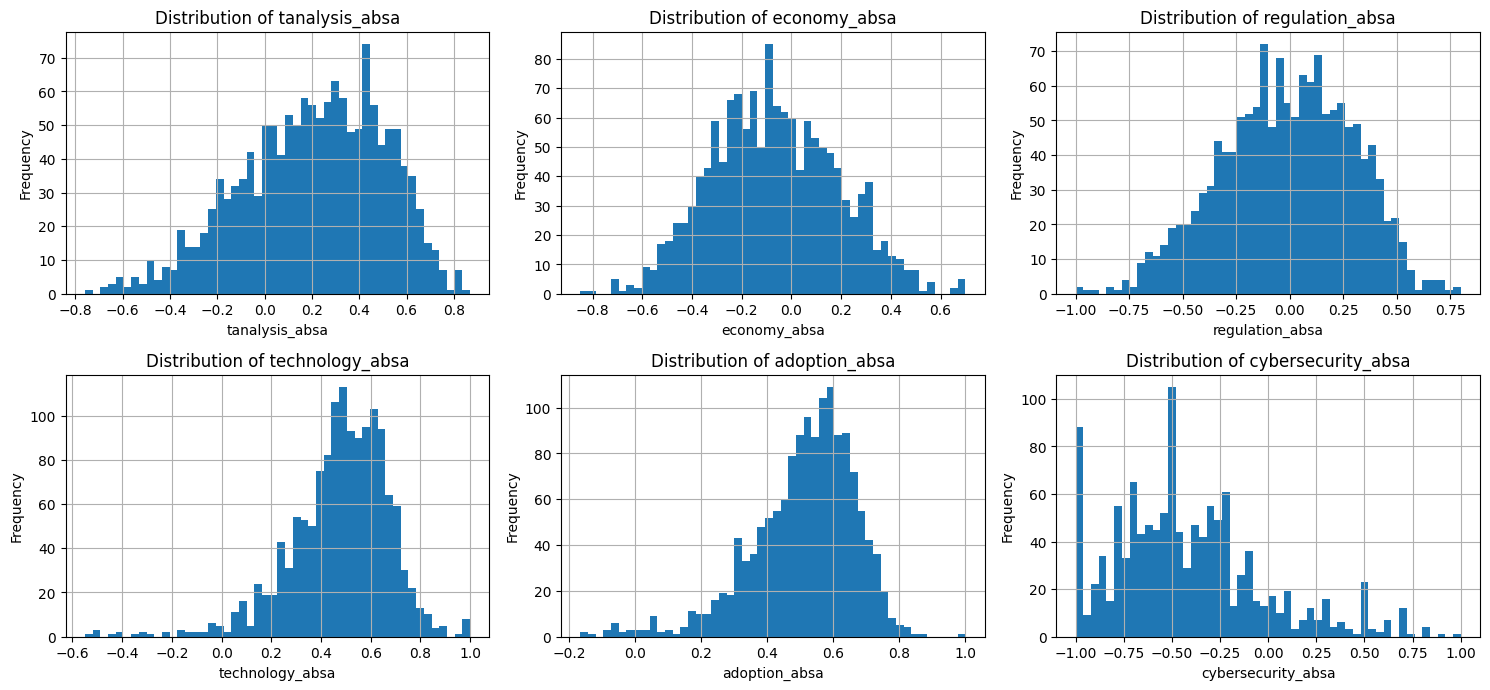

In [6]:
# plot the distribution of the columns
# columns = ['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa',
#        'technology_absa', 'adoption_absa', 'cybersecurity_absa', 'return_forward_1d']

columns = ['tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(columns):
  df[column].hist(ax=axes[i], bins=50)
  axes[i].set_title(f'Distribution of {column}')
  axes[i].set_xlabel(column)
  axes[i].set_ylabel('Frequency')

# Remove empty subplots
for j in range(len(columns), len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

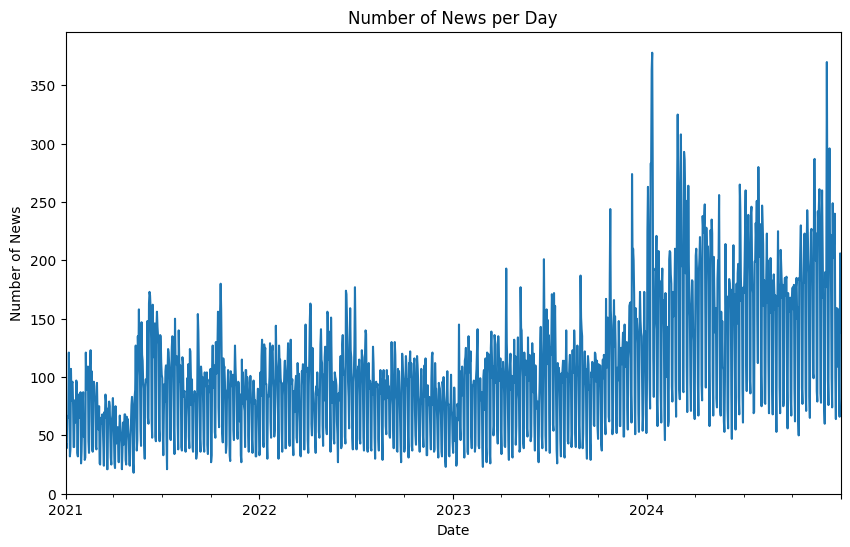

In [18]:
df['news_count'].plot(kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Number of News')
plt.title('Number of News per Day')
plt.show()

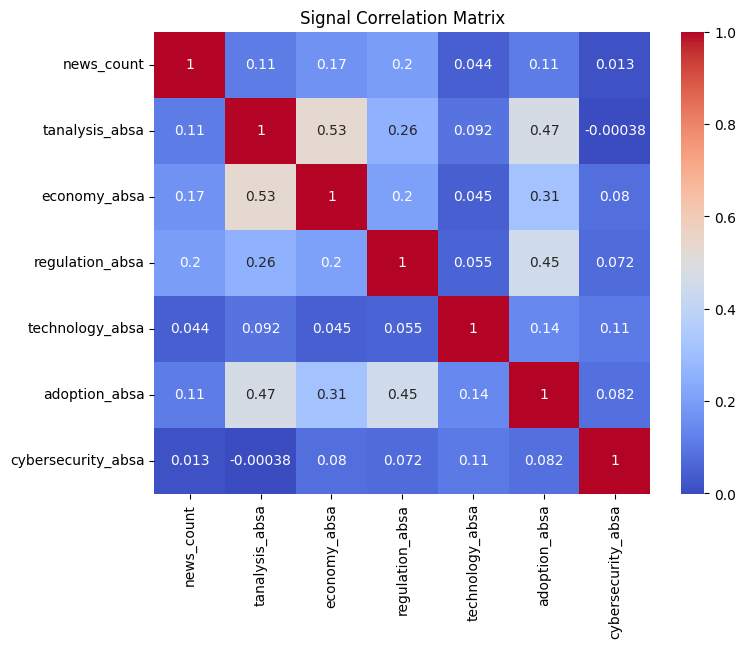

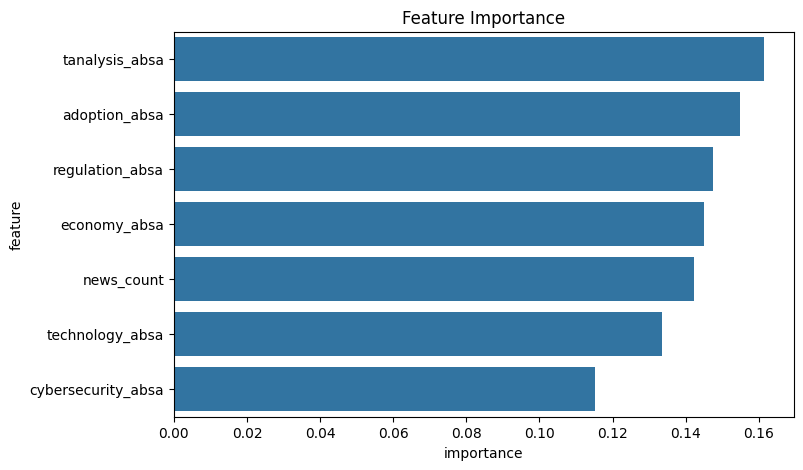


Statistical Analysis:
              feature    f_score       p_value
1      tanalysis_absa  32.140325  1.726121e-08
5       adoption_absa  18.622930  1.700162e-05
2        economy_absa   8.499293  3.607082e-03
4     technology_absa   5.372281  2.059695e-02
3     regulation_absa   2.344793  1.259190e-01
6  cybersecurity_absa   1.386492  2.391904e-01
0          news_count   0.058373  8.091209e-01


In [19]:
def analyze_features(df, signal_columns):
  # 1. Correlation Analysis
  correlation_matrix = df[signal_columns].corr()
  plt.figure(figsize=(8, 6))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
  plt.title('Signal Correlation Matrix')
  plt.show()
  
  # 2. Feature Importance using Random Forest
  X = df[signal_columns].fillna(method='ffill').fillna(method='bfill') # Forward fill then backward fill
  y = df['return_forward_1d']
  rf = RandomForestRegressor(n_estimators=100, random_state=42)
  rf.fit(X, y)
  
  importance_df = pd.DataFrame({
      'feature': signal_columns,
      'importance': rf.feature_importances_
  }).sort_values('importance', ascending=False)
  
  plt.figure(figsize=(8, 5))
  sns.barplot(data=importance_df, x='importance', y='feature')
  plt.title('Feature Importance')
  plt.show()
  
  # 3. Statistical Analysis
  f_scores, p_values = f_regression(X, y)
  stats_df = pd.DataFrame({
    'feature': signal_columns,
    'f_score': f_scores,
    'p_value': p_values
  }).sort_values('f_score', ascending=False)
  
  print("\nStatistical Analysis:")
  print(stats_df)
  
  return correlation_matrix, importance_df, stats_df

signal_columns = ['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
corr_matrix, importance, stats = analyze_features(df, signal_columns)

Overall Annual Return: 79.12%
Overall Annual Sharpe Ratio: 3.1302
Maximum Drawdown: -13.05 %
Win/Loss Ratio: 1.2
Alpha: 0.7751
Beta: 0.0334

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       1.712271    0.337250     0.061969      1.662260       5.077153
1  2022       0.637624    0.256901    -0.225579      0.446132       2.481981
2  2023       0.336980    0.175875     0.186096      0.137224       1.916026
3  2024       0.478830    0.205564     0.230169      0.271864       2.329346


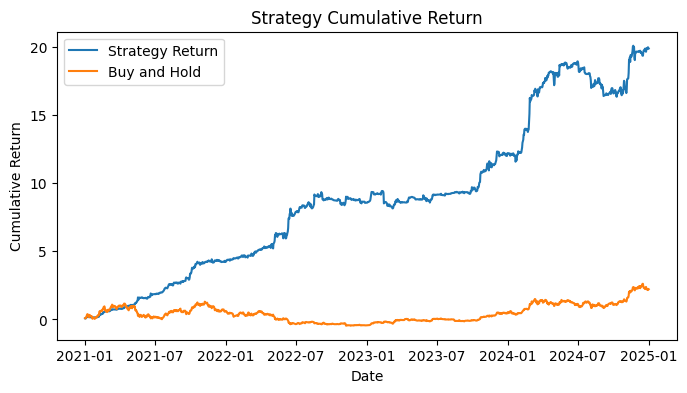

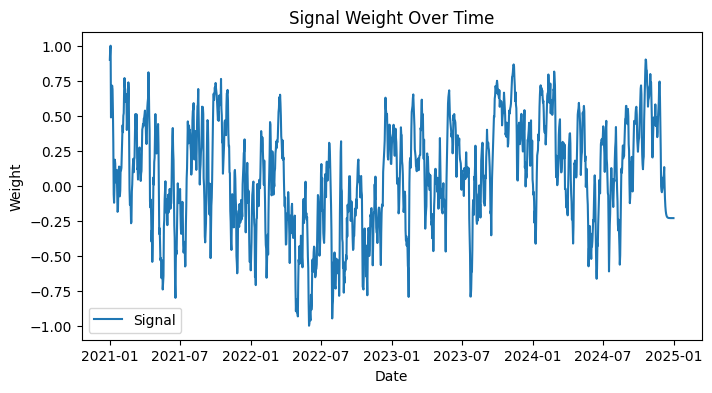

In [20]:
# backtest tanalysis_absa as signal
df['signal'] = df['tanalysis_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=4).mean() # 4 days ewm gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 33.58%
Overall Annual Sharpe Ratio: 1.315
Maximum Drawdown: -25.06 %
Win/Loss Ratio: 1.15
Alpha: 0.4291
Beta: -0.1932

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.567559    0.256907    -0.090129      0.640297       2.209203
1  2022       0.660227    0.389229    -0.574467      0.172567       1.696245
2  2023      -0.057106    0.153088    -0.161169      0.115894      -0.373025
3  2024       0.172886    0.139963     0.091096      0.090974       1.235230


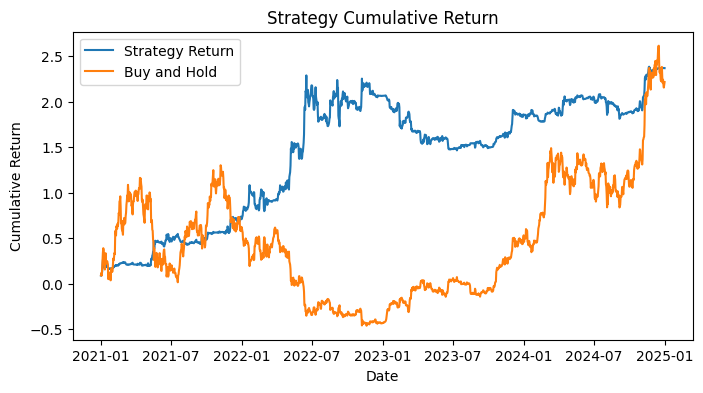

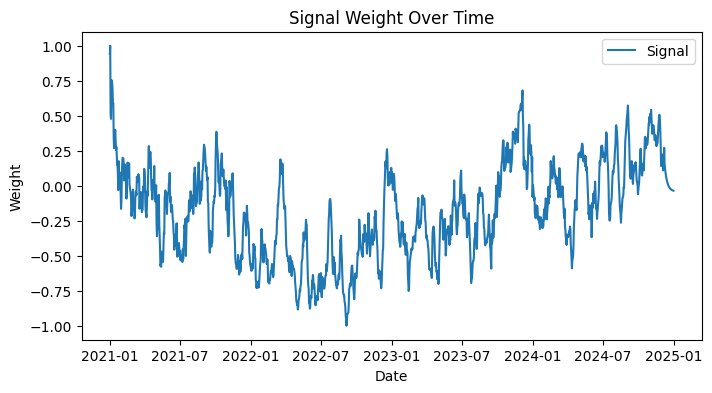

In [21]:
# backtest economy_absa as signal
df['signal'] = df['economy_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=13).mean() # 13 days ewm gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 22.63%
Overall Annual Sharpe Ratio: 0.9333
Maximum Drawdown: -35.65 %
Win/Loss Ratio: 0.97
Alpha: 0.2211
Beta: 0.0107

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.407202    0.339106    -0.143290      0.522842       1.200809
1  2022       0.025050    0.209296     0.054547      0.071355       0.119689
2  2023       0.005888    0.188763     0.023003     -0.018803       0.031195
3  2024       0.466391    0.201981     0.286902      0.208411       2.309083


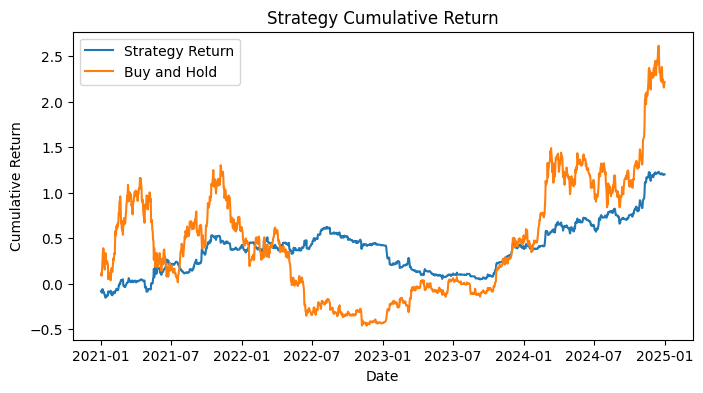

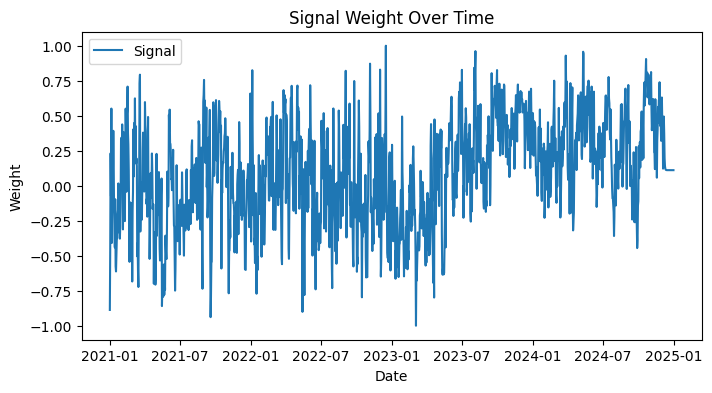

In [22]:
# backtest regulation_absa as signal
df['signal'] = df['regulation_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=2).mean()

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 35.11%
Overall Annual Sharpe Ratio: 1.378
Maximum Drawdown: -34.07 %
Win/Loss Ratio: 1.02
Alpha: 0.2011
Beta: 0.3106

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.687598    0.316224     0.272192      0.467928       2.174404
1  2022      -0.230779    0.260366     0.301352      0.025036      -0.886364
2  2023       0.424347    0.202038     0.392339      0.003208       2.100332
3  2024       0.522748    0.224269     0.353078      0.205264       2.330891


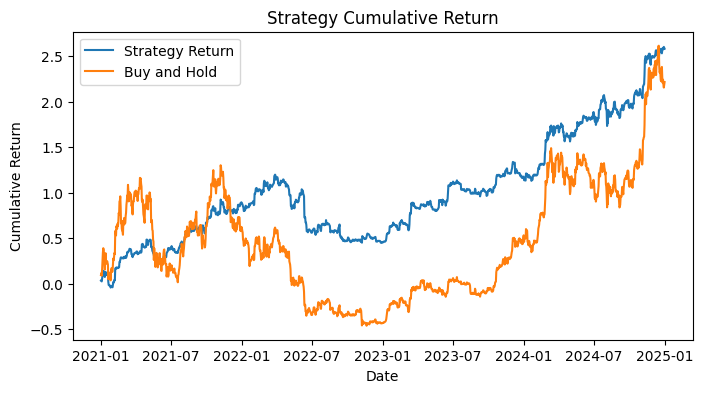

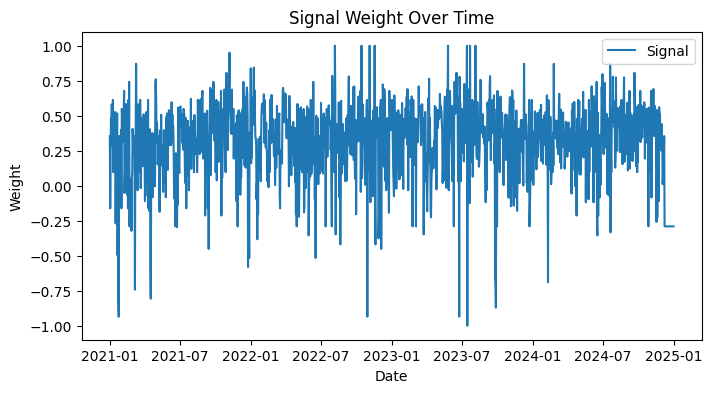

In [23]:
# backtest technology_absa as signal
df['signal'] = df['technology_absa']
df['signal'] = df['signal'].fillna(0)

# no smoothing gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 47.21%
Overall Annual Sharpe Ratio: 2.1982
Maximum Drawdown: -14.07 %
Win/Loss Ratio: 1.06
Alpha: 0.4053
Beta: 0.1382

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       1.140936    0.302318     0.174027      1.000489       3.773964
1  2022       0.196342    0.195788     0.044340      0.233982       1.002829
2  2023       0.182147    0.130867     0.153087      0.017822       1.391842
3  2024       0.369255    0.190657     0.179068      0.208239       1.936755


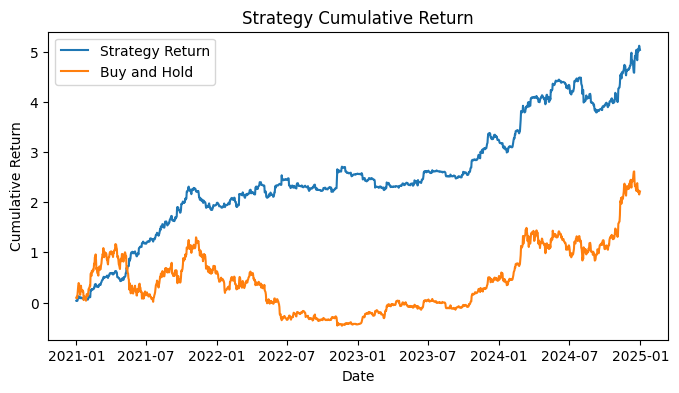

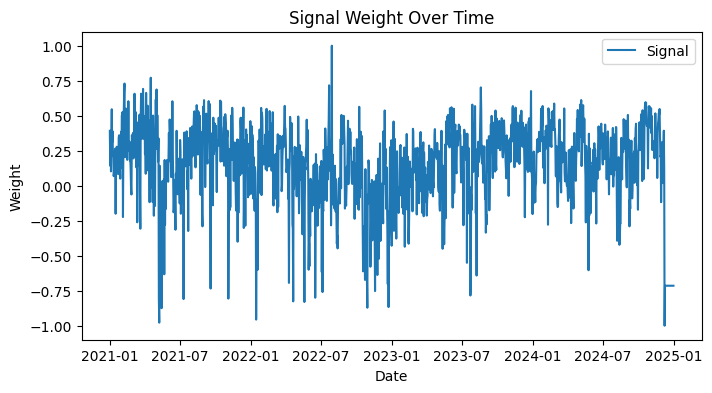

In [24]:
# backtest adoption_absa as signal
df['signal'] = df['adoption_absa']
df['signal'] = df['signal'].fillna(0)

# no smmothing gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: -8.43%
Overall Annual Sharpe Ratio: -0.2781
Maximum Drawdown: -57.73 %
Win/Loss Ratio: 1.05
Alpha: 0.0484
Beta: -0.2747

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.181002    0.404135    -0.294896      0.418995       0.447875
1  2022       0.096975    0.280824    -0.237011     -0.104222       0.345324
2  2023      -0.347931    0.248326    -0.294372     -0.031950      -1.401104
3  2024      -0.266803    0.253043    -0.271526     -0.022650      -1.054376


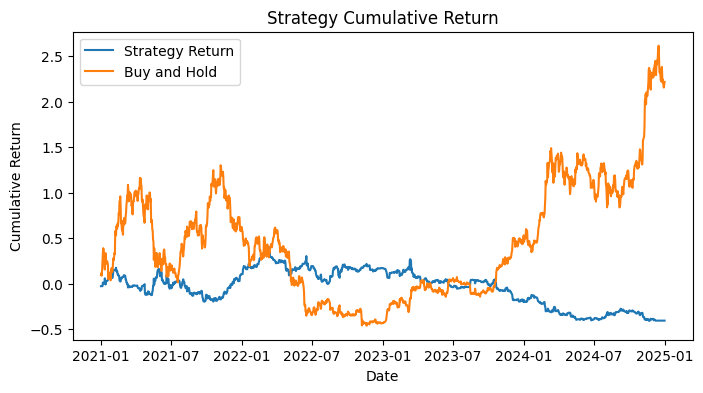

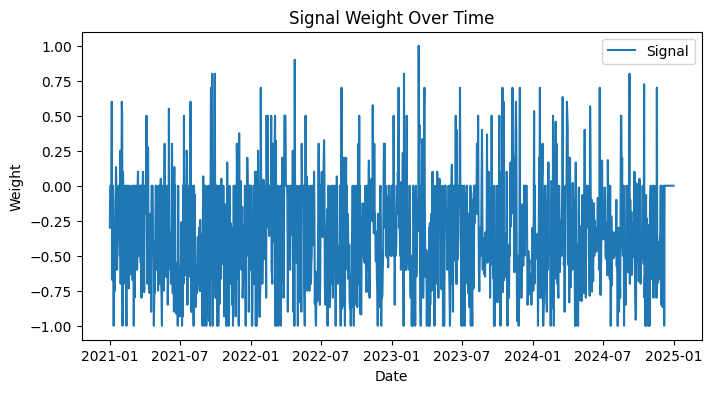

In [25]:
# backtest cybersecurity_absa as signal
df['signal'] = df['cybersecurity_absa']
df['signal'] = df['signal'].fillna(0)

# no smoothing gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

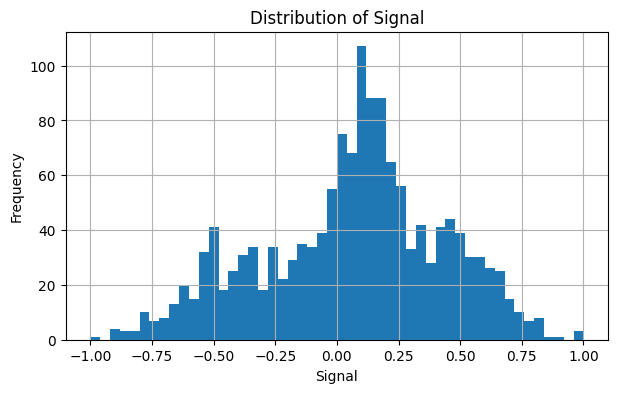

Overall Annual Return: 3.34%
Overall Annual Sharpe Ratio: 0.1413
Maximum Drawdown: -31.97 %
Win/Loss Ratio: 1.02
Alpha: 0.0335
Beta: -0.0001

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021      -0.070599    0.298082    -0.138548      0.041215      -0.236844
1  2022      -0.110507    0.190670    -0.061827     -0.162991      -0.579570
2  2023       0.090586    0.149415     0.000114      0.090464       0.606269
3  2024       0.223692    0.276812     0.397871     -0.134070       0.808098


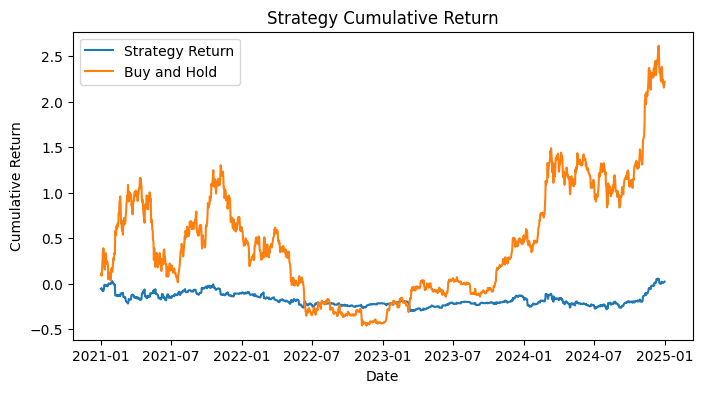

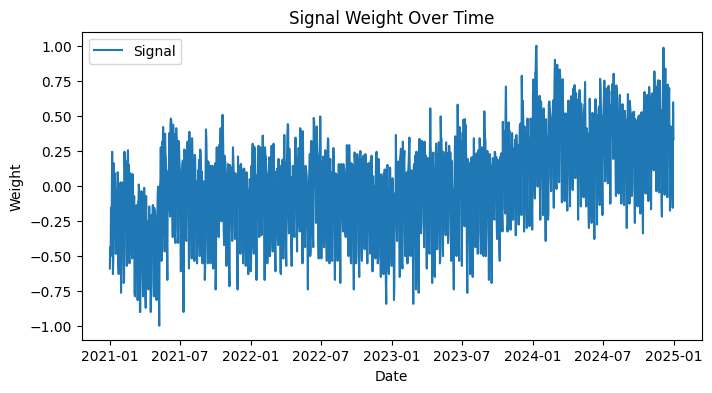

In [26]:
# backtest news_count as signal
df['signal'] = df['news_count']
df['signal'] = df['signal'].fillna(0)

# feature scaling, right skewed, log transformation
df['signal'] = np.log1p(df['signal'])

# scale the signal to be between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

# plot the distribution of the signal
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

run_backtest(df)


### strategy 4: improved random forest classifer

In [27]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward_1d
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.093726
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,0.020380
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.024712
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.063197
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.083311


In [28]:
df = df.fillna(0)

# apply ewm (based on previous analysis)
df['tanalysis_absa'] = df['tanalysis_absa'].ewm(span=4).mean()
df['economy_absa'] = df['economy_absa'].ewm(span=13).mean()
df['regulation_absa'] = df['regulation_absa'].ewm(span=2).mean()

# remove insignificant features (based on previous analysis)
df.drop(columns=['news_count', 'cybersecurity_absa'], inplace=True)

In [29]:
df.head()

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,return_forward_1d
2021-01-01,0.744828,0.450000,-0.700000,0.5,0.645455,0.093726
2021-01-02,0.796498,0.476923,-0.400000,0.1,0.500000,0.020380
2021-01-03,0.810653,0.254331,0.084615,0.4,0.616667,-0.024712
2021-01-04,0.473519,0.237466,-0.130000,0.6,0.476471,0.063197
2021-01-05,0.519703,0.326254,0.308471,0.5,0.650000,0.083311


In [30]:
df['signal'] = 0
df.loc[df['return_forward_1d'] > 0.01, 'signal'] = 1
df.loc[df['return_forward_1d'] < -0.01, 'signal'] = -1

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.3554


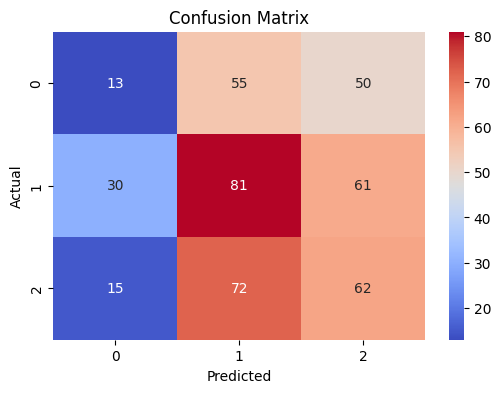

Classification Report:
               precision    recall  f1-score   support

          -1       0.22      0.11      0.15       118
           0       0.39      0.47      0.43       172
           1       0.36      0.42      0.39       149

    accuracy                           0.36       439
   macro avg       0.32      0.33      0.32       439
weighted avg       0.33      0.36      0.34       439



In [ ]:
# split dataset to 7:3
train_size = int(len(df) * 0.7)
test_size = int(len(df) * 0.3)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# split to X and y
X_train = train_df[['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa']]
y_train = train_df['signal']
X_test = test_df[['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa']]
y_test = test_df['signal']

# Random Forest Regressor

# Hyperparameter Grid
param_grid = {
  'n_estimators': [50, 100, 200],
  'max_depth': [10, 20, 30],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [2, 4, 6],
  'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
  estimator=rf,
  param_grid=param_grid,
  cv=5,
  n_jobs=-1,
  scoring='accuracy',
  verbose=1
)

# Train the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Initialize the best estimator
best_rf = grid_search.best_estimator_

# Predict on Test Set
y_pred = best_rf.predict(X_test)

# Evaluation Metrics
accuracy = best_rf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Overall Annual Return: 51.8%
Overall Annual Sharpe Ratio: 1.3181
Maximum Drawdown: -40.91 %
Win/Loss Ratio: 1.08
Alpha: 0.2029
Beta: 0.2868

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023       1.184313    0.374742     0.619063     -0.114794       3.160339
1  2024       0.385108    0.396647     0.235617      0.173244       0.970910


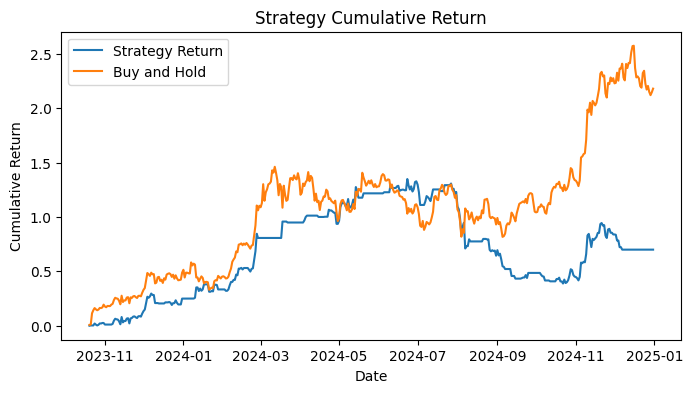

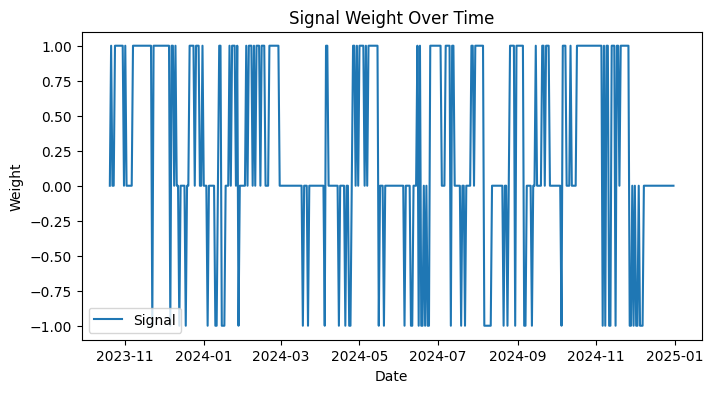

In [32]:
test_df['signal'] = y_pred
run_backtest(test_df)

### Strategy 5: Best ABSA: tanalysis_absa (based on previous analysis)

In [33]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward_1d
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.093726
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,0.020380
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.024712
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.063197
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.083311


Overall Annual Return: 79.12%
Overall Annual Sharpe Ratio: 3.1302
Maximum Drawdown: -13.05 %
Win/Loss Ratio: 1.2
Alpha: 0.7751
Beta: 0.0334

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       1.712271    0.337250     0.061969      1.662260       5.077153
1  2022       0.637624    0.256901    -0.225579      0.446132       2.481981
2  2023       0.336980    0.175875     0.186096      0.137224       1.916026
3  2024       0.478830    0.205564     0.230169      0.271864       2.329346


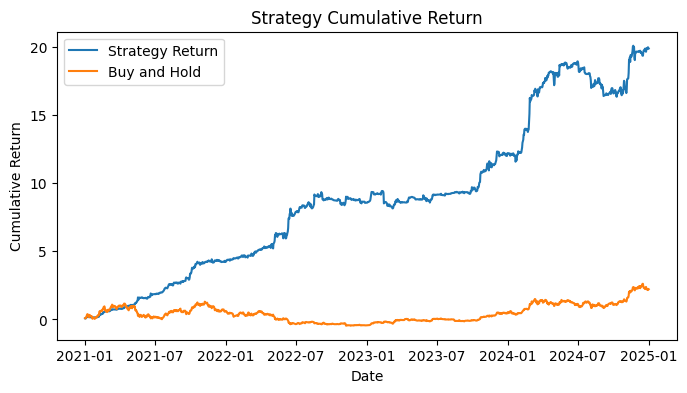

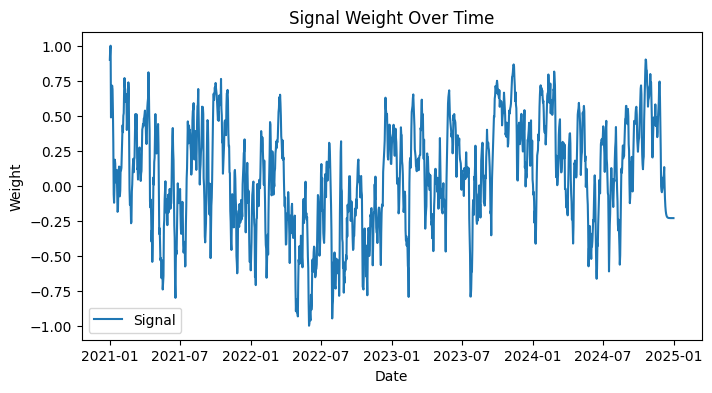

In [ ]:
df = df.fillna(0)

# apply ewm
df['tanalysis_absa'] = df['tanalysis_absa'].ewm(span=4).mean()
df['signal'] = df['tanalysis_absa']

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 47.88%
Overall Annual Sharpe Ratio: 2.3293
Maximum Drawdown: -13.05 %
Win/Loss Ratio: 1.17
Alpha: 0.2719
Beta: 0.2302

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024        0.47883    0.205564     0.230169      0.271864       2.329346


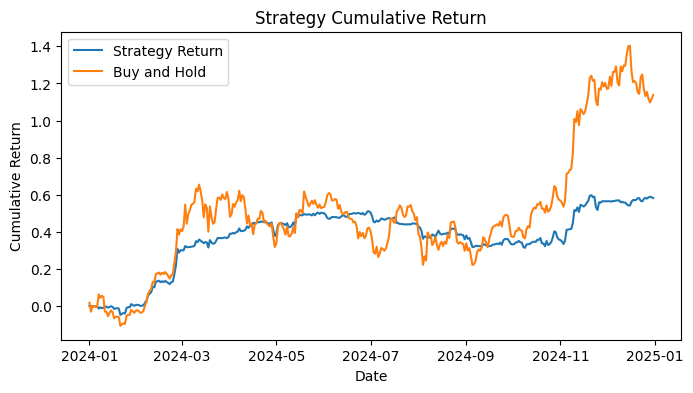

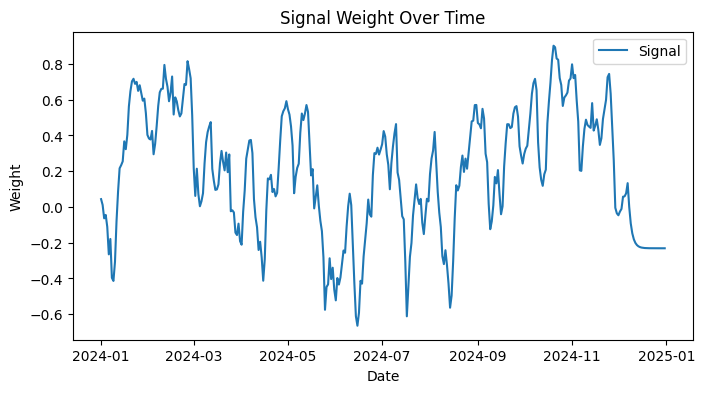

In [35]:
# backtest 2024 only
df = df[df.index.year == 2024]

run_backtest(df)